In [1]:
import pandas as pd
from tqdm import tqdm
# import gensim
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from joblib import Parallel, delayed
import sys
from scipy.stats import norm

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
# tf.config.set_visible_devices([], 'GPU')

from tqdm.notebook import tqdm
tf.random.set_seed(seed_value)
import multiprocessing


No GPU found


In [3]:
import matplotlib.pyplot as plt

import pickle

In [4]:
path = os.getcwd() + "//dataset_1"

In [5]:
# ## read in all the drug features
# ## for train test and valid
train_drugs = np.load(path + "//" + "train_drug.npy")

In [6]:
idxs = list(set(range(0, train_drugs.shape[1])))

In [7]:
train_omics = np.load(path + "//" + "train_omics.npy")[:, idxs]

In [8]:
train_omics.shape

(500, 90)

In [9]:
train_omics1 = np.load(path + "//" + "train_omics.npy")

In [10]:
def ann(hidden = 10, input_shape = 90): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(1)
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [11]:
# X_train_word2vec = train_drugs

In [12]:
h1, h2 = 16,16

In [13]:


ann_15 = ann(h1)


# In[35]:


# ann_15.summary()


# In[36]:



In [14]:
ann_15.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90)]              0         
                                                                 
 dense (Dense)               (None, 16)                1456      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


In [15]:
# X_train_word2vec = train_omics

In [16]:
ann_20 = ann(h2, 90)



# ann_20.summary()



In [17]:
total_weights_1 = ann_15.count_params()

In [18]:
total_weights_2 = ann_20.count_params()

In [19]:
total_weights = total_weights_1 + total_weights_2 + 1 

In [20]:
total_weights

2947

In [21]:
## batch size
batch_size = 128

In [22]:
# var_weights = 0.08
# var_targets = 0.08

In [23]:
from scipy.stats import multivariate_normal as mvn

In [24]:
from scipy.stats import invgamma, norm

In [25]:
from tqdm.notebook import tqdm

In [26]:
threshold = 5

In [27]:
import random

In [28]:
lr = 0.1

In [29]:
import numpy as np

In [30]:
weights_ann_1 = ann_15.get_weights()
weights_ann_2 = ann_20.get_weights()

In [31]:
def get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1, size_ens): 

    n_hidden_1 = len(weights_ann_1[0].ravel())

    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)

    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)



    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, 1)

    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + 1)].reshape(size_ens, 1, 1)



    final_output_1 = output_1 + output_layer_bias_1

    n_hidden_2 = len(weights_ann_2[0].ravel())

    initial_ensembles_1 = initial_ensembles.copy()[:, total_weights_1:(total_weights_1+ total_weights_2)]
    
    # print(batch_data1.shape[1])
    
    
    hidden_weights_2 = initial_ensembles_1[:,:n_hidden_2].reshape(size_ens, batch_data1.shape[1], h2)



    hidden_output_2 = np.einsum('ij,kjl->kil', batch_data1, hidden_weights_2)

    hidden_layer_bias_2 = initial_ensembles[:,n_hidden_2:(n_hidden_2 + h2)].reshape(size_ens, 1,  h2)

    hidden_output_2 = hidden_output_2+ hidden_layer_bias_2

    n_pred_weights_2 = len(weights_ann_2[2].ravel())

    output_weights_2 = initial_ensembles_1[:,(n_hidden_2 + h2):(n_hidden_2 + h2 + n_pred_weights_2) ].reshape(size_ens, h2, 1)


    output_2 = np.einsum('ijk,ikl->ijl', hidden_output_2, output_weights_2)


    output_layer_bias_2 = initial_ensembles_1[:,(n_hidden_2 + h2 + n_pred_weights_2):(n_hidden_2 + h2 + n_pred_weights_2 + 1)].reshape(size_ens, 1, 1)


    final_output_2 = output_2 + output_layer_bias_2


    weights_1 = initial_ensembles[:, :total_weights_1]

    weights_2 = initial_ensembles[:, total_weights_1:(total_weights_1 + total_weights_2)]


    avg_weights = initial_ensembles[:, -1].reshape(-1,1)

    avg_weights_sig = expit(avg_weights)
    
    avg_weights_sig = avg_weights_sig.reshape(avg_weights_sig.shape[0], 1, avg_weights_sig.shape[1])
    
    complement_weights_sig = 1 - expit(avg_weights)
    
    complement_weights_sig = complement_weights_sig.reshape(complement_weights_sig.shape[0], 1, complement_weights_sig.shape[1])

    final_output_1 = final_output_1*complement_weights_sig
    
    final_output_2 = final_output_2*avg_weights_sig
    
    output_1_ravel = final_output_1.reshape(size_ens, final_output_1.shape[1]*final_output_1.shape[2])

    output_2_ravel = final_output_2.reshape(size_ens, final_output_2.shape[1]*final_output_2.shape[2])


    output_1_ravel = output_1_ravel

    output_2_ravel = output_2_ravel



    weights_1_add = np.zeros((size_ens, (total_weights_2 - total_weights_1)))



    weights_1 = np.hstack((weights_1, weights_1_add))
    


    stack_1 = np.hstack((output_1_ravel, weights_1, np.repeat(0, size_ens).reshape(-1,1), np.repeat(0, size_ens).reshape(-1,1)))



    
    stack_2 = np.hstack((output_2_ravel, weights_2, avg_weights, log_sigma_points_1))

    
    initial_aug_state = np.hstack((stack_1, stack_2)) 
    

    return initial_aug_state , output_1_ravel, output_2_ravel, log_sigma_points_1



In [32]:
import time

In [33]:
from scipy.stats import multivariate_normal as mvn

In [34]:
from scipy.stats import multivariate_normal as mvn

In [35]:
# train_fudged_probs

In [36]:
import matplotlib.pyplot as plt

In [37]:
from scipy.special import expit

In [38]:
# catch1[0][0]

In [39]:
# catch_train_logits_second[0]

In [40]:
from datetime import datetime

In [41]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [42]:
from scipy.stats import gamma

In [43]:
use_cores = multiprocessing.cpu_count()-1

In [44]:
use_cores

47

In [45]:
from datetime import datetime

In [46]:
from sklearn.metrics import mean_squared_error

In [47]:
import random

In [48]:
from scipy import stats

In [49]:
from scipy.stats import pearsonr

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
from sklearn.model_selection import KFold

In [52]:
path = os.getcwd() + "//dataset_" + str(0 + 1) + "/"
train_drugs_1 = np.load(path + "//" + "train_drug.npy")
valid_drugs_1 = np.load(path + "//" + "valid_drug.npy")
test_drugs_1 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_1 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_1 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_1 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_1 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_1 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_1 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [53]:
path = os.getcwd() + "//dataset_" + str(1 + 1) + "/"
train_drugs_2 = np.load(path + "//" + "train_drug.npy")
valid_drugs_2 = np.load(path + "//" + "valid_drug.npy")
test_drugs_2 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_2 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_2 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_2 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_2 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_2 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_2 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [54]:
path = os.getcwd() + "//dataset_" + str(1 + 2) + "/"
train_drugs_3 = np.load(path + "//" + "train_drug.npy")
valid_drugs_3 = np.load(path + "//" + "valid_drug.npy")
test_drugs_3 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_3 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_3 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_3 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_3 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_3 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_3 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [55]:
path = os.getcwd() + "//dataset_" + str(1 + 3) + "/"
train_drugs_4 = np.load(path + "//" + "train_drug.npy")
valid_drugs_4 = np.load(path + "//" + "valid_drug.npy")
test_drugs_4 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_4 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_4 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_4 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_4 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_4 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_4 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [56]:
path = os.getcwd() + "//dataset_" + str(1 + 4) + "/"
train_drugs_5 = np.load(path + "//" + "train_drug.npy")
valid_drugs_5 = np.load(path + "//" + "valid_drug.npy")
test_drugs_5 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_5 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_5 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_5 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_5 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_5 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_5 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [57]:
path = os.getcwd() + "//dataset_" + str(1 + 5) + "/"
train_drugs_6 = np.load(path + "//" + "train_drug.npy")
valid_drugs_6 = np.load(path + "//" + "valid_drug.npy")
test_drugs_6 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_6 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_6 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_6 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_6 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_6 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_6 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [58]:
path = os.getcwd() + "//dataset_" + str(1 + 6) + "/"
train_drugs_7 = np.load(path + "//" + "train_drug.npy")
valid_drugs_7 = np.load(path + "//" + "valid_drug.npy")
test_drugs_7 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_7 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_7 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_7 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_7 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_7 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_7 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [59]:
path = os.getcwd() + "//dataset_" + str(1 + 7) + "/"
train_drugs_8 = np.load(path + "//" + "train_drug.npy")
valid_drugs_8 = np.load(path + "//" + "valid_drug.npy")
test_drugs_8 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_8 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_8 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_8 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_8 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_8 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_8 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [60]:
path = os.getcwd() + "//dataset_" + str(1 + 8) + "/"
train_drugs_9 = np.load(path + "//" + "train_drug.npy")
valid_drugs_9 = np.load(path + "//" + "valid_drug.npy")
test_drugs_9 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_9 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_9 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_9 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_9 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_9 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_9 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [61]:
path = os.getcwd() + "//dataset_" + str(1 + 9) + "/"
train_drugs_10 = np.load(path + "//" + "train_drug.npy")
valid_drugs_10 = np.load(path + "//" + "valid_drug.npy")
test_drugs_10 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_10 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_10 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_10 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_10 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_10 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_10 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [62]:
train_drugs = np.vstack((train_drugs_1,train_drugs_2, train_drugs_3, train_drugs_4,train_drugs_5, train_drugs_6,
                        train_drugs_7,train_drugs_8, train_drugs_9, train_drugs_10))

In [63]:
train_omics = np.vstack((train_omics_1,train_omics_2, train_omics_3, train_omics_4,train_omics_5, train_omics_6, 
                        train_omics_7,train_omics_8, train_omics_9, train_omics_10))

In [64]:
valid_drugs = np.vstack((valid_drugs_1,valid_drugs_2, valid_drugs_3, valid_drugs_4,valid_drugs_5, valid_drugs_6,
                        valid_drugs_7,valid_drugs_8, valid_drugs_9, valid_drugs_10))

In [65]:
valid_omics = np.vstack((valid_omics_1,valid_omics_2, valid_omics_3, valid_omics_4,valid_omics_5, valid_omics_6, 
                        valid_omics_7,valid_omics_8, valid_omics_9, valid_omics_10))

In [66]:
test_drugs = np.vstack((test_drugs_1,test_drugs_2, test_drugs_3, test_drugs_4,test_drugs_5, test_drugs_6,
                        test_drugs_7,test_drugs_8, test_drugs_9, test_drugs_10))

In [67]:
test_omics = np.vstack((test_omics_1,test_omics_2, test_omics_3, test_omics_4,test_omics_5, test_omics_6, 
                        test_omics_7,test_omics_8, test_omics_9, test_omics_10))

In [68]:
test_omics.shape

(1000, 90)

In [69]:
y_train = np.vstack((y_train_1,y_train_2, y_train_3, y_train_4,y_train_5, y_train_6, y_train_7,y_train_8, y_train_9, y_train_10))

In [70]:
y_valid = np.vstack((y_valid_1,y_valid_2, y_valid_3, y_valid_4,y_valid_5, y_valid_6, y_valid_7,y_valid_8, y_valid_9, y_valid_10))

In [71]:
y_test = np.vstack((y_test_1,y_test_2, y_test_3, y_test_4,y_test_5, y_test_6, y_test_7,y_test_8, y_test_9, y_test_10))

In [72]:
y_train.shape

(5000, 1)

In [73]:
y_valid.shape

(1000, 1)

In [74]:
y_test.shape

(1000, 1)

In [75]:
from sklearn.decomposition import PCA

In [76]:
train_drugs = np.vstack((train_drugs, valid_drugs, test_drugs))

In [77]:
train_omics = np.vstack((train_omics, valid_omics, test_omics))

In [78]:
train_omics.shape

(7000, 90)

In [79]:
y_train = np.vstack((y_train, y_valid, y_test))

In [80]:
train_drugs.shape

(7000, 90)

In [81]:
y_train.shape

(7000, 1)

In [82]:
kf = KFold(n_splits = 7, random_state=42, shuffle = True)

In [83]:
# kf.get_n_splits(train_drugs)

In [84]:
train_ids = []
# valid_ids = []
test_ids = []
# test_ids = []
for i, (train_index, test_index) in enumerate(kf.split(train_drugs)): 
    train_ids.append(train_index)
    test_ids.append(test_index)

In [85]:
# len(test_ids[0])

In [86]:
# batch_size = 1000

In [87]:
# train_idx = list(range(0, len(y_train)))
# batch_chunks_train = [train_idx[i:i+batch_size] for i in range(0,len(y_train),batch_size)]

In [88]:
# np.max(batch_chunks_train[0])

In [89]:
# batch_size = 200
# valid_idx = list(range(0, len(y_valid)))
# batch_chunks_valid = [valid_idx[i:i+batch_size] for i in range(0,len(y_valid),batch_size)]

In [90]:
# len(batch_chunks_valid)

In [91]:
# train_ids

In [92]:
def rep_one_real_world(train_ids_f, test_ids_f, size_ens): 
    train_rmse = []
    test_rmse = []
    train_cov = []
    test_cov = []
    train_p = []
    test_p = []
    train_width = []
    test_width = []
#     from scipy.special import expit
    patience_smaller = 0
    patience_uns = 0
    
    print("Size_Ens is " + str(size_ens), flush = True)
    
    best_train_mae = 100000
    
    best_train_width = 100000

        
    X_train_logits_unshuffled = y_train.reshape(-1,1)[train_ids_f,:]
    train_size = X_train_logits_unshuffled.shape[0]
    
    random_idx = list(random.sample(range(0,train_size), k = int(0.1667*train_size)))
#     X_train_logits = catch_train_logits_second[idx]
    
    not_random_idx = list(set(range(0,train_size)).difference(random_idx))
    
    X_train_logits_unshuffled1 = X_train_logits_unshuffled[not_random_idx, :]
    X_valid_logits = X_train_logits_unshuffled[random_idx,:]
    X_test_logits = y_train.reshape(-1,1)[test_ids_f,:]
    
    ## create training batch chunks
    train_idx = list(range(0, len(X_train_logits_unshuffled1)))
    batch_chunks = [train_idx[i:i+batch_size] for i in range(0,len(X_train_logits_unshuffled1),batch_size)]

    ## generate some augmented variable for iteration 0
    initial_aug_state_mean = np.repeat(0, total_weights)
    initial_aug_state_mean = initial_aug_state_mean.reshape(-1,1)

    initial_aug_state_cov = var_weights*np.identity((total_weights))
    initial_ensembles = mvn(initial_aug_state_mean.reshape(initial_aug_state_mean.shape[0],), initial_aug_state_cov).rvs(size = size_ens)

    exit_iter_no_thresh = 0
    log_sigma_points_1 = (np.log(gamma(gamma_param, scale = 1/100).rvs(size_ens))).reshape(size_ens, 1)
    

#     y_train = catch_train_labels_second[idx]

#     y_valid = catch_valid_labels_second[idx]

#     y_test = catch_test_labels_second[idx]
    
    
    train_lstm = train_drugs[train_ids_f,:]
    # valid_lstm = train_lstm[random_idx,:]
    # train_lstm1 = train_lstm[not_random_idx,:]
    # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
    test_lstm = train_drugs[test_ids_f,:]

    # pca = PCA(n_components=train_omics.shape[1])
    # train_lstm = pca.fit_transform(train_lstm)
    # # valid_lstm = pca.transform(valid_lstm)
    # test_lstm = pca.transform(test_lstm)
    
    # print(train_lstm.shape)

    train_doc2vec = train_omics[train_ids_f,:]
    # valid_doc2vec = train_doc2vec[random_idx,:]
    # train_doc2vec1 = train_doc2vec[not_random_idx,:]
    # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
    test_doc2vec = train_omics[test_ids_f,:]
    
    

    
    # train_valid_lstm = (train_lstm)
    # train_valid_doc2vec = (train_doc2vec)
    
    # print(train_valid_lstm.shape)

    
    
    best_coverage_train = 0
    
    start = datetime.now()
    
    for iter1 in range(0,500):
        random_idx = random.sample(range(0,train_lstm.shape[0]), train_lstm.shape[0])
        train_valid_lstm =train_lstm[random_idx, :]
        train_valid_doc2vec = train_doc2vec[random_idx, :]
        X_train_logits = X_train_logits_unshuffled[random_idx, :]

        for batch_idx in batch_chunks:
            
            batch_data = train_valid_lstm[batch_idx,:]
            # print(batch_data.shape)
            batch_data1 = train_valid_doc2vec[batch_idx,:]
            # print(batch_data1.shape)
            batch_targets = X_train_logits[batch_idx,:]
            
            # print(batch_targets.shape)
            
            # batch_targets = batch_targets.ravel().reshape(-1,1)

            column_mod_2_shape = total_weights_2 + batch_data.shape[0]*1 + 1 + 1
        
            H_t = np.hstack((np.identity(batch_targets.shape[0]), np.zeros((batch_targets.shape[0], column_mod_2_shape-batch_targets.shape[0]))))
            
            
            
            
            current_aug_state, column_mod_1, column_mod_2, log_sigma_points_1 = get_targets_with_weights(batch_data1, batch_data, initial_ensembles, log_sigma_points_1, size_ens)
            
            # print(current_aug_state.shape)
            
            
            var_targets_vec = np.log(1 + np.exp(log_sigma_points_1))
            
            var_targets_vec = var_targets_vec
            
            # current_aug_state_var = np.cov(current_aug_state.T) + inflation_factor*np.identity(current_aug_state.shape[1])
            
            current_aug_state_var = np.cov(current_aug_state.T) 
            
            G_t = np.array([1 , 1]).reshape(-1,1)
            
            scirpt_H_t = np.kron(G_t.T, H_t)
            
            temp1 = current_aug_state_var@scirpt_H_t.T
            
            temp2 = scirpt_H_t@current_aug_state_var@scirpt_H_t.T

            R_t1 = var_targetsw*np.identity(current_aug_state.shape[1])
            
            measurement_error1 = mvn(np.repeat(0,current_aug_state.shape[1]), R_t1).rvs(current_aug_state.shape[0])
        
            for ensemble_idx in range(0, current_aug_state.shape[0]):
                
                var_targets1 = var_targets_vec[ensemble_idx,:]
                
                R_t = var_targets1*np.identity(batch_targets.shape[0])
            
                measurement_error = mvn(np.repeat(0,batch_targets.shape[0]), var_targets1*np.identity(batch_targets.shape[0])).rvs(1).reshape(-1,1)
            
                target_current = batch_targets + measurement_error
                
                # print(target_current.shape)
                
                K_t = temp1@np.linalg.inv(temp2 + R_t)
                
                # print(K_t.shape)

                current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] +(K_t@(target_current -scirpt_H_t@current_aug_state[ensemble_idx,:].reshape(-1,1))).reshape(current_aug_state.shape[1],)
                
                current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] + measurement_error1[ensemble_idx,:]

            weights_ann_1 = current_aug_state[:,batch_targets.shape[0]:(batch_targets.shape[0] + total_weights_1)]      

            weights_ann_2 = current_aug_state[:,-(total_weights_2+1):-2]    

            initial_ensembles = np.hstack((weights_ann_1, weights_ann_2, current_aug_state[:,-2].reshape(-1,1)))
            
            log_sigma_points_1 = current_aug_state[:,-1].reshape(-1,1)
               
            avg_betas = expit(current_aug_state[:,-2])
        
            complement = 1-avg_betas

#             current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(valid_doc2vec, valid_lstm, initial_ensembles, log_sigma_points_1)
            
#             initial_targets = column_mod_11 + column_mod_21
            
            
#             initial_targets = initial_targets.reshape(size_ens, valid_lstm.shape[0],1)
            
#             initial_targets_train = initial_targets
            
#             initial_targets_train_mean = initial_targets_train.mean(0)
            
#             li = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]
            
#             ui = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:]
            
#             width = ui - li
            
#             avg_width_valid = np.mean(width)
            
#             # interim = np.vstack((catch_train_probs[idx] , catch_valid_probs[idx] ))
        
#             interim = (X_valid_logits)
            
#             ind = (interim >= li) & (interim <= ui)
            
#             coverage_valid= np.mean(ind.ravel())  
            
#             valid_mae = np.sqrt(mean_squared_error(interim, initial_targets_train_mean))
            
#             stats_pearson_valid = stats.pearsonr(interim.reshape(interim.shape[0],),
#                                            initial_targets_train_mean.reshape(initial_targets_train_mean.shape[0],))

            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(train_doc2vec, train_lstm, initial_ensembles, log_sigma_points_1, size_ens)
            
            initial_targets = column_mod_11 + column_mod_21
            
            
            initial_targets = initial_targets.reshape(size_ens, train_lstm.shape[0],1)
            
            initial_targets_train = initial_targets
            
            initial_targets_train_mean = initial_targets_train.mean(0)
            
            li = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width_train = np.mean(width)
            
            # interim = np.vstack((catch_train_probs[idx] , catch_valid_probs[idx] ))
        
            interim = (X_train_logits_unshuffled)
            
            ind = (interim >= li) & (interim <= ui)
            
            coverage_train= np.mean(ind.ravel())  
            
            train_mae = np.sqrt(mean_squared_error(interim, initial_targets_train_mean))
            
            # plt.scatter(interim, initial_targets_train_mean)
            # plt.show()
            
            stats_pearson_train = stats.pearsonr(interim.reshape(interim.shape[0],),
                                           initial_targets_train_mean.reshape(initial_targets_train_mean.shape[0],))

            # train_mae = np.sqrt(np.mean(np.abs(interim.ravel() - initial_targets_train_mean.ravel())**2))
        
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_doc2vec, test_lstm, initial_ensembles, log_sigma_points_1, size_ens)
            
            initial_targets = column_mod_11 + column_mod_21
            
            initial_targets = initial_targets.reshape(size_ens, test_lstm.shape[0],1)
            
            initial_targets_test = initial_targets
            
            # initial_targets_softmax = expit(initial_targets)    
            
            initial_targets_test_mean = initial_targets_test.mean(0)
            
            li = np.percentile(initial_targets_test, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_test, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width = np.mean(width)
            
            catch_test_probs = (X_test_logits)
            
            ind_test = (catch_test_probs >= li) & (catch_test_probs <= ui)
                        
            coverage_test = np.mean(ind_test.ravel())    

            
            test_mae = np.sqrt(mean_squared_error(catch_test_probs, initial_targets_test_mean))

            stats_pearson = stats.pearsonr(catch_test_probs.reshape(catch_test_probs.shape[0],),
                                           initial_targets_test_mean.reshape(initial_targets_test_mean.shape[0],))


            train_rmse.append(train_mae)
            test_rmse.append(test_mae)
            train_cov.append(coverage_train)
            test_cov.append(coverage_test)
            train_p.append(stats_pearson_train)
            test_p.append(stats_pearson)
            train_width.append(avg_width_train)
            test_width.append(avg_width)
            
            if  train_mae < best_train_mae: 
                patience = 0
                best_train_mae = train_mae
                # best_valid_mae = valid_mae
                best_test_mae = test_mae
                exit_iter_no_thresh = iter1
                best_test_preds = initial_targets_test
                patience_smaller = 0
                best_train_coverage = coverage_train
                # best_valid_coverage = coverage_valid
                best_test_coverage = coverage_test
                best_train_width = avg_width_train
                # best_valid_width = avg_width_valid
                best_test_width = avg_width
                best_drugs_weight = np.mean(complement)
                best_r_test = stats_pearson[0]
                best_r_train = stats_pearson_train[0]
                # best_r_valid = stats_pearson_valid[0]
                best_initial_ensembles = initial_ensembles
                best_log_sigma_points_1 = log_sigma_points_1
                best_initial_targets_test_mean = initial_targets_test_mean
                best_li = li
                best_ui = ui
            else:
                patience += 1
                
#             print("epoch "+ str(iter1))
#             print("patience "+ str(patience))
#             print("train mae is " + str(train_mae))
#             # print("valid mae is " + str(valid_mae))
#             print("test mae is " + str(test_mae))
        
#             print("train coverage is "+ str(coverage_train))
#             # print("valid coverage is "+ str(coverage_valid))
#             print("test coverage is "+ str(coverage_test))
            
#             print("train width is " + str(avg_width_train))
#             # print("valid width is " + str(avg_width_valid))  
#             print("test width is " + str(avg_width))
            
#             print("drugs weight is " + str(np.mean(complement)))
#             print("pearson r train is " + str(stats_pearson_train[0]))
#             # print("pearson r valid is " + str(stats_pearson_valid[0]))
#             print("pearson r test is " + str(stats_pearson[0]))
            
            
                
            if patience >= threshold: 
                break
                
        if patience >= threshold: 
                break
            
    
    # print(best_valid_mae, best_valid_coverage, best_valid_width,best_r_valid, flush = True)
    print(best_test_mae, best_test_coverage, best_test_width,best_r_test, flush = True)
    end = datetime.now()
    total = (end- start)
    time_taken = total.seconds/60.0
    return size_ens, best_train_mae, best_test_mae, best_train_coverage, best_test_coverage,  \
    best_train_width , best_test_width,  best_drugs_weight, best_r_train, best_r_test, exit_iter_no_thresh, time_taken, best_initial_ensembles, best_log_sigma_points_1, [X_test_logits.tolist(), best_initial_targets_test_mean.tolist()], \
    [best_li.tolist(), best_ui.tolist()], train_rmse, test_rmse, train_cov, test_cov, train_p, test_p, train_width, test_width 
        
    # print("something went awry", flush = True)

In [93]:
var_weights =1
gamma_param = 500
var_targetsw = 0.02
reduction = 100
shape_needed = total_weights//reduction
size_ens = shape_needed
size_ens = int(size_ens)
batch_size = 512
threshold = 10

In [94]:
size_ens

29

In [95]:
# size_ens,best_train_mae, best_test_mae, best_train_coverage, best_test_coverage,  \
#     best_train_width , best_test_width,  best_drugs_weight, best_r_train, best_r_test, exit_iter_no_thresh, time_taken, best_initial_ensembles, best_log_sigma_points_1, _, _, train_rmse, test_rmse, train_cov, test_cov, train_p, test_p, train_width, test_width = rep_one_real_world(train_ids[4], test_ids[4], size_ens)

In [96]:
# test_actual_preds[0].shape

In [97]:
# len(test_actual_preds)

In [98]:
# test_actual_preds, best_li_ui

In [99]:
from joblib import Parallel, delayed

In [100]:
# test_actual_preds[:5]

In [101]:
# best_li_ui[0]

In [102]:
grid_ns =  [25, 50,100,125,150,175,200,225,250,300,325,350,375,400]

In [103]:
len(grid_ns)

14

In [104]:
catch = Parallel(n_jobs = 14, backend = "loky", verbose = 8)(delayed(rep_one_real_world)(train_ids[4], test_ids[4], size_ens) for size_ens in grid_ns)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


Size_Ens is 25
Size_Ens is 50
Size_Ens is 100
Size_Ens is 125
Size_Ens is 150
Size_Ens is 175
Size_Ens is 200
Size_Ens is 225
Size_Ens is 250
Size_Ens is 300
Size_Ens is 325
Size_Ens is 350
Size_Ens is 375
Size_Ens is 400
2.323949008318122 0.664 4.721374202636569 0.4515026606816859
1.474326366818726 0.904 5.117668093539292 0.7371807803977685
1.4504298569032117 0.948 6.000629571221808 0.7487998392675418


[Parallel(n_jobs=14)]: Done   3 out of  14 | elapsed: 36.3min remaining: 132.9min


1.45303830071632 0.943 6.040447772953806 0.7591999484748021
1.3447268506857577 0.967 5.958667317327318 0.7889918287696333


[Parallel(n_jobs=14)]: Done   5 out of  14 | elapsed: 48.4min remaining: 87.1min


1.3897066965117244 0.971 6.773441184768679 0.7775933504461789
1.409449831881401 0.982 6.806369505720879 0.7644729085476236


[Parallel(n_jobs=14)]: Done   7 out of  14 | elapsed: 54.0min remaining: 54.0min


1.3229851585017114 0.972 6.482869118605169 0.7946673521660597
1.403881460102662 0.989 7.505421571825109 0.7729472333740106


[Parallel(n_jobs=14)]: Done   9 out of  14 | elapsed: 56.0min remaining: 31.1min


1.4229844082496075 0.998 11.14223443110253 0.7696482610947262
1.37821990750089 0.966 6.175962073707267 0.7837412229672391


[Parallel(n_jobs=14)]: Done  11 out of  14 | elapsed: 67.4min remaining: 18.4min


1.4125453583512009 0.991 7.807681017129995 0.7683176041884145
1.362056736547767 0.981 6.976587260175065 0.7878958608368253
1.4666321616740206 0.987 7.8609491175710176 0.7584386587885326


[Parallel(n_jobs=14)]: Done  14 out of  14 | elapsed: 84.8min finished


In [105]:
with open("Preds_with_PCA_proper_CV_no_valid_all_features_diff_size_ens" + ".pkl", 'wb') as f:
    pickle.dump(catch, f)

In [103]:
with open("Preds_with_PCA_proper_CV_no_valid_all_features_diff_size_ens" + ".pkl", 'rb') as f:
    catch = pickle.load(f)

In [104]:
col_names = ['size_ens','best_train_mae', 'best_test_mae', 'best_train_coverage', 'best_test_coverage',  \
    'best_train_width' , 'best_test_width',  'best_drugs_weight', 'best_r_train', 'best_r_test']

In [105]:
catch_df = pd.DataFrame(catch).iloc[:,:len(col_names)]

In [106]:
catch_df.columns = col_names

In [ ]:
# catch_df.columns = ['best_train_mae', 'best_test_mae', 'best_train_coverage', 'best_test_coverage',  \
#     'best_train_width' , 'best_test_width',  'best_drugs_weight', 'best_r_train', 'best_r_test']

In [107]:
catch_df.head()

,size_ens,best_train_mae,best_test_mae,best_train_coverage,best_test_coverage,best_train_width,best_test_width,best_drugs_weight,best_r_train,best_r_test
0,25,2.294259,2.323949,0.683833,0.664,4.738893,4.721374,0.451787,0.446154,0.451503
1,50,1.477525,1.474326,0.909333,0.904,5.131114,5.117668,0.463341,0.712703,0.737181
2,100,1.437567,1.453038,0.943500,0.943,6.054139,6.040448,0.434621,0.749325,0.759200
3,125,1.410482,1.450430,0.959833,0.948,5.997548,6.000630,0.458971,0.744938,0.748800
4,150,1.379066,1.378220,0.961667,0.966,6.198541,6.175962,0.480842,0.762048,0.783741


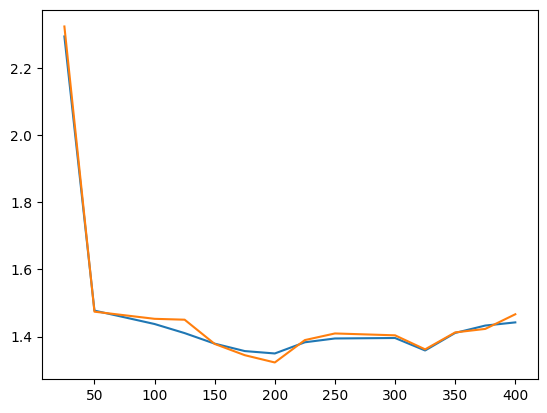

In [108]:
plt.plot(catch_df['size_ens'], catch_df['best_train_mae'])
plt.plot(catch_df['size_ens'], catch_df['best_test_mae'])
plt.show()

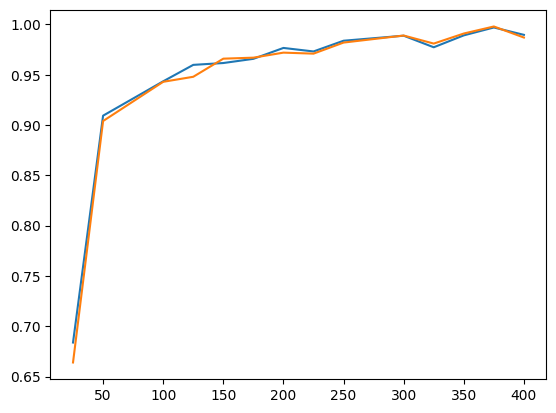

In [109]:
plt.plot(catch_df['size_ens'], catch_df['best_train_coverage'])
plt.plot(catch_df['size_ens'], catch_df['best_test_coverage'])
plt.show()

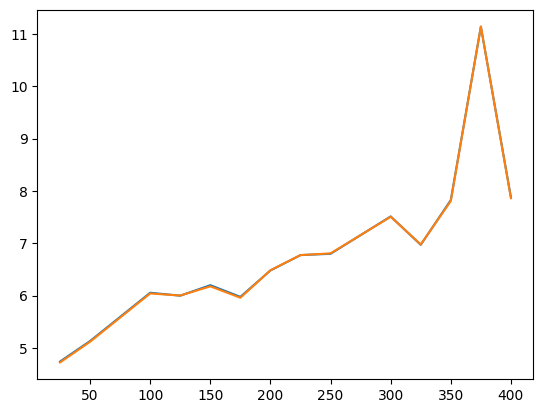

In [110]:
plt.plot(catch_df['size_ens'], catch_df['best_train_width'])
plt.plot(catch_df['size_ens'], catch_df['best_test_width'])
plt.show()

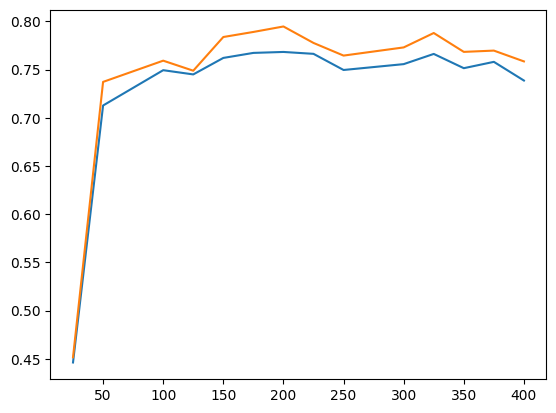

In [111]:
plt.plot(catch_df['size_ens'], catch_df['best_r_train'])
plt.plot(catch_df['size_ens'], catch_df['best_r_test'])
plt.show()

In [117]:
catch_df = []
for i in range(0, len(catch)): 
    item = catch[i]
    size_ens = item[0]
    train_rmse = item[-7]
    test_rmse = item[-8]
    df = pd.DataFrame({"Train_RMSE": train_rmse, 
                      "Test_RMSE": test_rmse})
    df["size_ens"] = size_ens
    df["update_iteration"] = np.array(range(0, df.shape[0])) + 1
    catch_df.append(df)

In [118]:
catch_df = pd.concat(catch_df)

In [119]:
catch_df.head()

,Train_RMSE,Test_RMSE,size_ens,update_iteration
0,4.169387,4.142220,25,1
1,3.344189,3.341956,25,2
2,2.323949,2.294259,25,3
3,2.986836,2.986811,25,4
4,2.271993,2.311486,25,5


In [274]:
# catch_df = catch_df[catch_df["size_ens"] != 25]

In [120]:
catch_df.dtypes

Train_RMSE          float64
Test_RMSE           float64
size_ens              int64
update_iteration      int64
dtype: object

In [121]:
sizes = [ 50, 100, 200, 300, 400]

In [122]:
catch_df = catch_df[catch_df["size_ens"].isin(sizes)]

In [202]:
# logical_ids = [True if (float(size_ens)%100) == 0 else False for size_ens in catch_df['size_ens'].values ]

In [123]:
catch_df["size_ens"] = catch_df["size_ens"].astype(str)

In [124]:
catch_df.shape

(127, 4)

In [154]:
# !pip install seaborn

In [125]:
import seaborn as sns

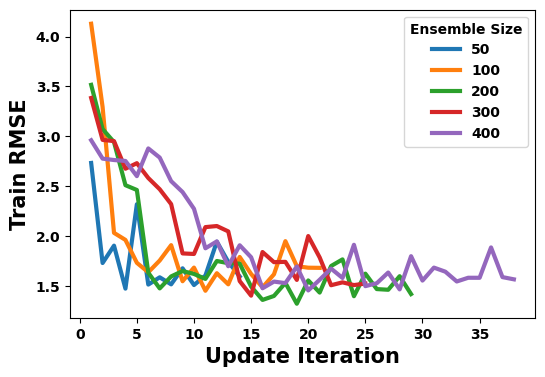

In [129]:
fig = plt.figure(figsize = (6,4))
sns.lineplot(data=catch_df, x="update_iteration", y="Train_RMSE", hue="size_ens", linewidth = 3)
plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("Train RMSE", fontsize = 15, fontweight = "bold")
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
leg = plt.legend(title = "Ensemble Size",fontsize=10, prop =  {'weight':'bold'}, labelcolor = "black", 
                title_fontproperties=  {'weight':'bold'})
for legobj in leg.legend_handles:
    legobj.set_linewidth(3.0)
fig.savefig('Plots/Different_Ensemble_Size.pdf', bbox_inches='tight', format = "pdf")
fig.savefig('Plots/Different_Ensemble_Size.png', bbox_inches='tight')
plt.show()

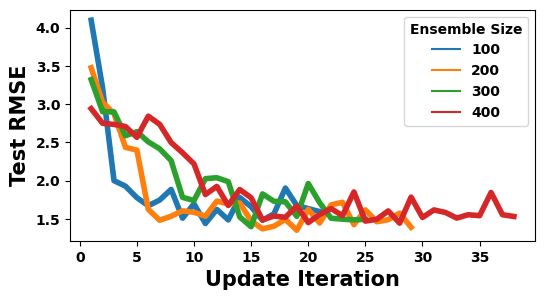

In [239]:
plt.figure(figsize = (6,3))
sns.lineplot(data=catch_df, x="update_iteration", y="Test_RMSE", hue="size_ens", linewidth = 4)
plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("Test RMSE", fontsize = 15, fontweight = "bold")
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
leg = plt.legend(title = "Ensemble Size",fontsize=10, prop =  {'weight':'bold'}, labelcolor = "black", 
                title_fontproperties=  {'weight':'bold'})
plt.show()

In [ ]:
# catch_df['best_drugs_weight'] = 1 - catch_df['best_drugs_weight']

In [ ]:
# catch_df.mean()

In [ ]:
# pca = PCA(n_components = test_omics.shape[1])
# pca.fit(train_drugs)

In [ ]:
# test_drugs = pca.transform(test_drugs)

In [ ]:
# test_drugs.shape

In [ ]:
# preds_test_catch = []
# test_catch = []
# li_catch = []
# ui_catch = []
# for i in range(0,6):
#     preds = catch[i][-2][1]
#     actual = catch[i][-2][0]
#     preds_test_catch.append(preds)
#     test_catch.append(actual)
# #     best_log_sigma_points_1 = catch[i][-3]
# #     current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_omics, test_drugs, params, best_log_sigma_points_1)
            
# #     initial_targets_test = column_mod_11 + column_mod_21
            
# #     initial_targets_test = initial_targets_test.reshape(size_ens, test_omics.shape[0],1)
            
# #     initial_targets_test_mean = initial_targets_test.mean(0)
    
#     # preds_test_catch.append(preds)
    
#     li = catch[i][-1][0]
#     li_catch.append(li)
            
#     ui = catch[i][-1][1]
#     ui_catch.append(ui)
            
# #     width = ui - li
            
# #     avg_width = np.mean(width)

In [ ]:
# preds_test_catch = [inner for item in preds_test_catch for inner in item]

In [ ]:
# test_catch = [inner for item in test_catch for inner in item]

In [ ]:
# li_catch =  [inner for item in li_catch for inner in item]

In [ ]:
# ui_catch =  [inner for item in ui_catch for inner in item]

In [ ]:
# avg_width

In [ ]:
# y_test_preds = np.array(preds_test_catch).mean(0)

In [ ]:
# y_test_preds.shape

In [ ]:
# ui

In [ ]:
# current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_omics, test_drugs, best_initial_ensembles, best_log_sigma_points_1)
            
# initial_targets = column_mod_11 + column_mod_21
            
# initial_targets = initial_targets.reshape(size_ens, test_omics.shape[0],1)
            
# initial_targets_test = initial_targets

In [ ]:
# # initial_targets_softmax = expit(initial_targets)    
            
# initial_targets_test_mean = initial_targets_test.mean(0)
            
# li = np.percentile(initial_targets_test, axis = 0, q = (2.5, 97.5))[0,:,:]
            
# ui = np.percentile(initial_targets_test, axis = 0, q = (2.5, 97.5))[1,:,:]
            
# width = ui - li
            
# avg_width = np.mean(width)
            
# catch_test_probs = (y_test)
            
# ind_test = (catch_test_probs >= li) & (catch_test_probs <= ui)
                        
# coverage_test = np.mean(ind_test.ravel())    

            
# test_mae = np.sqrt(mean_squared_error(catch_test_probs, initial_targets_test_mean))

# stats_pearson = stats.pearsonr(catch_test_probs.reshape(catch_test_probs.shape[0],),
#                                            initial_targets_test_mean.reshape(initial_targets_test_mean.shape[0]))

In [ ]:
# stats_pearson

In [ ]:
# string = "Real_World_EnKF_DeepCDR_" + "Neurons_" + str(h1)  + "_Gamma_" +  str(gamma_param) +  "_var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens)

In [ ]:
# string = "First_Three_Real_World_EnKF_DeepCDR_" + "Neurons_" + str(h1)  + "_Gamma_" +  str(gamma_param) +  "_var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens)

In [ ]:
# string

In [ ]:
# catch_coverages = [best_train_mae, best_valid_mae, best_test_mae, best_train_coverage, best_test_coverage, best_valid_coverage, best_test_coverage, \
#     best_train_width, best_valid_width , best_test_width, best_drugs_weight, best_r_train, best_r_valid, best_r, exit_iter_no_thresh, time_taken, best_initial_ensembles, best_log_sigma_points_1]

In [ ]:
# best_train_mae, best_valid_mae, best_test_mae, best_train_coverage, best_test_coverage, best_valid_coverage, best_test_coverage, \
#     best_train_width, best_valid_width , best_test_width, (1-best_drugs_weight), best_r_train, best_r_valid, best_r, exit_iter_no_thresh, time_taken, best_initial_ensembles, best_log_sigma_points_1

In [ ]:
# with open("Preds_Mutation_Methylation" + ".pkl", 'wb') as f:
#     pickle.dump(catch_coverages, f)

In [ ]:
# fig  = plt.figure()
# plt.scatter(y_test, initial_targets_test_mean, alpha = 0.5)
# plt.axline((0,0), slope = 1, c = "black", linewidth = 3)
# plt.xlabel("Observed Log IC50", fontweight = "bold", fontsize = 15)
# plt.ylabel("MEnKF-ANN Predicted Log IC50", fontweight = "bold", fontsize = 15)
# plt.xticks(fontsize = 15, fontweight = "bold")
# plt.yticks(fontsize = 15, fontweight = "bold")
# fig.savefig('Plots/Avg_Smile_Weight_Tajectory.pdf', bbox_inches='tight', format = "pdf")
# fig.savefig('Plots/Avg_Smile_Weight_Tajectory.png', bbox_inches='tight')
# plt.show()

In [ ]:
# catch_coverages

In [ ]:
# catch_coverages

In [ ]:
# check = pd.DataFrame(catch_coverages[:10])

In [ ]:
# check

In [ ]:
# check

In [ ]:
# check.columns = ["train_mae", "test_mae", "avg_ci_width_train", "avg_ci_width_test", "avg_lstm_weight", "exit_iter", "exit_status"]

In [ ]:
# check = check.T


In [ ]:
# check

In [ ]:
# check.columns = ["train_mae", "test_mae", "train_coverage", "train_width", "test_coverage", "test_width", "exit_iter", "time_taken", "avg_width_alginate"]

In [ ]:
# check.columns = ["train_mae", "test_mae", "train_coverage", "train_width", "test_coverage", "test_width", "drug_weight" , "pearson_correlation" ,"exit_iter", "time_taken"]

In [ ]:
# true_preds = [inner for item in true_preds for inner in item]

In [ ]:
# enkf_preds = [inner for item in enkf_preds for inner in item]

In [ ]:
# np.mean(np.abs(np.array(true_preds)-np.array(enkf_preds)))

In [ ]:
# plt.scatter(enkf_preds,true_preds, alpha=0.5)
# plt.xlabel("EnKF Predictions", fontsize = 15, fontweight = "bold")
# plt.ylabel("LSTM Predictions", fontsize = 15, fontweight = "bold")
# plt.xticks( fontsize = 10, fontweight = "bold")
# plt.yticks( fontsize = 10, fontweight = "bold")
# plt.axline((0, 0), slope=1)
# plt.show()

In [ ]:
# cur_idx = 0

In [ ]:
# catch_preds = []
# for i in range(0, catch_coverages[cur_idx][-1].shape[1]):
#     enkf_preds = catch_coverages[cur_idx][-1][:,i,:]
#     enkf_preds_df = pd.DataFrame(enkf_preds)
#     enkf_preds_df["Test_Sample_ID"] = i 
#     enkf_preds_df.columns = ["EnKF_Preds", "Test_Sample_ID"]
#     catch_preds.append(enkf_preds_df)

In [ ]:
# catch_preds_df = pd.concat(catch_preds)

In [ ]:
# import seaborn as sns

In [ ]:
# filtered_df = expit(catch1[cur_idx][2])

In [ ]:
# # plt.figure(figsize = (10,10))
# fig = sns.boxplot(catch_preds_df, x="Test_Sample_ID", y="EnKF_Preds", showfliers=False)
# plt.scatter(range(0, filtered_df.shape[0]), filtered_df, c = "black", s = 50)
# plt.xlabel("Test Sample ID", fontsize = 15, fontweight = "bold")
# plt.ylabel("EnKF Predictions", fontsize = 15, fontweight = "bold")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
# plt.show()

In [ ]:
# ids = [i for i in range(0, filtered_df.shape[0]) if filtered_df[i] < 0.5]
# ids_more = [i for i in range(0, filtered_df.shape[0]) if filtered_df[i] > 0.5]

In [ ]:
# catch_preds_df.groupby("Test_Sample_ID").quantile(q = [0.025, 0.975])

In [ ]:
# catch_preds_df_filtered = catch_preds_df[catch_preds_df["Test_Sample_ID"].isin(ids_more)]

In [ ]:
# filtered_true = filtered_df[ids_more,:]

In [ ]:
# # plt.figure(figsize = (10,10))
# fig = sns.boxplot(catch_preds_df_filtered, x="Test_Sample_ID", y="EnKF_Preds", showfliers=False)
# plt.scatter(range(0, filtered_true.shape[0]), filtered_true, c = "black", s = 50)
# plt.xlabel("Test Sample ID", fontsize = 15, fontweight = "bold")
# plt.ylabel("EnKF Predictions", fontsize = 15, fontweight = "bold")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
# plt.show()

In [ ]:
# catch_preds_df_filtered = catch_preds_df[catch_preds_df["Test_Sample_ID"].isin(ids)]
# filtered_true = filtered_df[ids,:]
# # plt.figure(figsize = (10,10))
# fig = sns.boxplot(catch_preds_df_filtered, x="Test_Sample_ID", y="EnKF_Preds", showfliers=False)
# plt.scatter(range(0, filtered_true.shape[0]), filtered_true, c = "black")
# plt.xlabel("Test Sample ID", fontsize = 15, fontweight = "bold")
# plt.ylabel("EnKF Predictions", fontsize = 15, fontweight = "bold")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
# plt.show()
# # plt.ylim((0.9,1.0))